In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.stats.contingency_tables import StratifiedTable
from scipy import stats
from tqdm.auto import tqdm

### Описание задания
А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

Описание колонок  
experimentVariant – вариант эксперимента  
version – версия приложения  
purchase – факт покупки  
 
Задача
Запустите A/A-тест  
Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR > альфа! Нам нужно наоборот – чтобы было меньше.  
Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)  
Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

In [2]:
# Загружаю данные эксперимента в ноутбук
sample = pd.read_csv('https://stepik.org/media/attachments/lesson/396012/hw_aa.csv', sep=';',index_col= 'Unnamed: 0')
sample

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


In [3]:
# Проверяю тип данных столбцов
sample.dtypes

uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [4]:
# Проверяю наличие дыр в данных
sample.isna().sum()

uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

In [5]:
# Проверяю наличие дубликатов в данных
sample.drop_duplicates().shape[0] - sample.shape[0]

0

In [6]:
#Выделяю датафреймы двух групп
exp  = sample.query('experimentVariant == 1')[['purchase', 'version']]
test = sample.query('experimentVariant == 0')[['purchase', 'version']]

In [7]:
exp

,purchase,version
1,0,v2.8.0
3,0,v2.9.0
4,0,v2.8.0
5,0,v2.8.0
6,0,v2.8.0
...,...,...
127010,0,v2.8.0
127011,0,v2.8.0
127016,0,v2.9.0
127017,0,v2.8.0


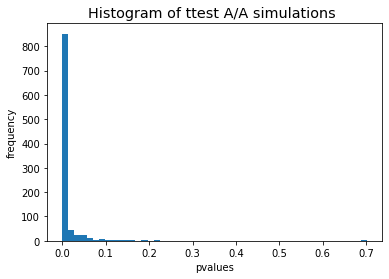

0.939

In [8]:
# Провожу А/А тест

simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = exp['purchase'].sample(n_s, replace = False).values
    s2 = test['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

Как мы видим по графику и FPR (~0.94 > 0.05) у нас сломанная сплит-система и мы не готовы к проведению A/B тестирования сейчас  
Задача на текущий момент: найти причину поломки

In [9]:
# Воспользуемся критерием Кохрана-Мантеля-Ханзеля для проверки дисбаланса
StratifiedTable.from_data('experimentVariant', 'purchase', 'version', sample).summary()

,Estimate,LCB,UCB
Pooled odds,2.300,2.161,2.447
Pooled log odds,0.833,0.771,0.895
Pooled risk ratio,1.031,,
,,,
,Statistic,P-value,
Test of OR=1,734.655,0.000,
Test constant OR,1256.880,0.000,
,,,
Number of tables,4,,
Min n,8425,,


Полученный результат позволяет нам отклонить нулевую гипотезу о независимости двух сравниваемых групп A/A тестирования (p-valueTest of OR=1 < 0.05)  
 Также отклоняем нулевую гипотезу об одинаковости взаимосвязи покупок двух групп по всем версиям приложений (p-value Test constant OR < 0.05)  
 Нужно поискать аномалии связанные с версией приложения, так как в одной или более версий наших групп имеются статистически значимые различия  

In [10]:
''' Создаю сводную таблицу где: 
    индекс - версия приложения
    колонка - номер группы
    значение - количество пользователей и коэфицент покупок в данной версии приложения
'''

sample \
    .groupby(['experimentVariant', 'version'], as_index=False) \
    .agg({'uid': 'count', 'purchase': 'mean'}) \
    .rename(columns={'uid': 'number'}) \
    .pivot(index='version', columns='experimentVariant', values=['number', 'purchase'])

number           purchase          
experimentVariant        0        1         0         1
version                                                
v2.8.0             41283.0  41552.0  0.000993  0.045606
v2.9.0             11921.0  12033.0  0.074658  0.071304
v3.7.4.0            4204.0   4221.0  0.059943  0.063018
v3.8.0.0            5694.0   6110.0  0.057604  0.062848

По внешней оценке сводоной таблицы можно увидеть значимую разницу коэфицента покупок в версии приложения 2.8.0  
В версии МП 3.8.0.0 есть небольшое различие (7%) в количестве респонедетов в группах  
Проверим каждую версию на отстутсвие статистически значимой разницы между группами  

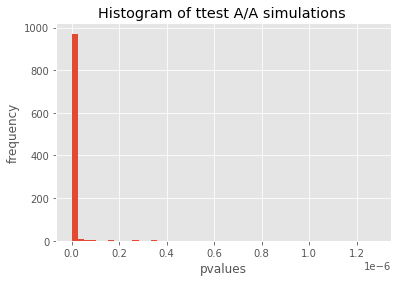

1.0

In [11]:
# Провожу А/А тест МП v2.8.0

simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = exp.query('version == "v2.8.0"')['purchase'].sample(n_s, replace = False).values
    s2 = test.query('version == "v2.8.0"')['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
fpr1 = sum(np.array(res) <0.05) / simulations
fpr1

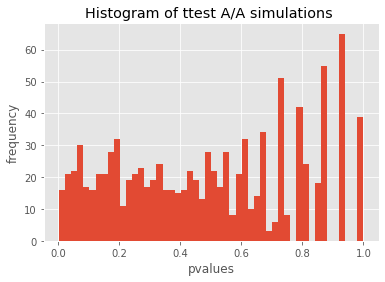

0.046

In [12]:
# Провожу А/А тест МП v2.9.0

simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = exp.query('version == "v2.9.0"')['purchase'].sample(n_s, replace = False).values
    s2 = test.query('version == "v2.9.0"')['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
fpr2 = sum(np.array(res) <0.05) / simulations
fpr2

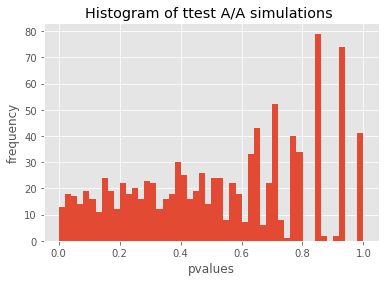

0.038

In [13]:
# Провожу А/А тест МП v3.7.4.0

simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = exp.query('version == "v3.7.4.0"')['purchase'].sample(n_s, replace = False).values
    s2 = test.query('version == "v3.7.4.0"')['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
fpr3 = sum(np.array(res) <0.05) / simulations
fpr3

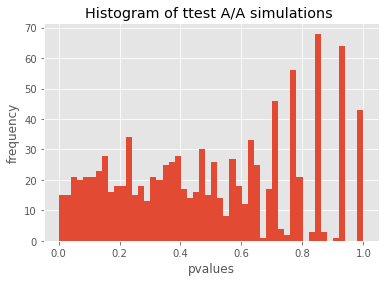

0.041

In [14]:
# Провожу А/А тест МП v3.8.0.0

simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = exp.query('version == "v3.8.0.0"')['purchase'].sample(n_s, replace = False).values
    s2 = test.query('version == "v3.8.0.0"')['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
fpr4 = sum(np.array(res) <0.05) / simulations
fpr4

In [16]:
# FPR разных версий приложения

print("FPR v2.8.0  :", fpr1)
print("FPR v2.9.0  :", fpr2)
print("FPR v3.7.4.0:", fpr3)
print("FPR v3.8.0.0:", fpr4)

FPR v2.8.0  : 1.0
FPR v2.9.0  : 0.046
FPR v3.7.4.0: 0.038
FPR v3.8.0.0: 0.041


По версии v2.8.0 сильно нарушено сплитование групп. В группах есть статистически значимые различия в коэфицентах покупок и FPR принимает максимальное значение  
FPR остальных версий приложения не превышает 0.05 и они успешно проходят А/А тест  

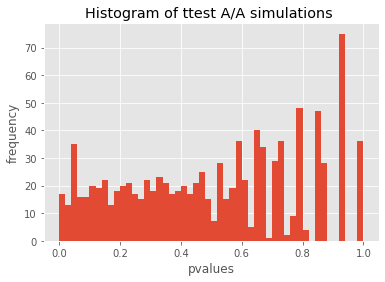

0.043

In [17]:
# Провожу А/А тест без версий МП, которые не прошли проверку отстуствия статистически значимых различий

simulations = 1000
n_s = 1000
res = []

# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = exp.query('version != "v2.8.0"')['purchase'].sample(n_s, replace = False).values
    s2 = test.query('version != "v2.8.0"')['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

A/A тест без аномальной версий приложения проходит проверку FPR < 0.05  
Теперь нужно найти причины по которым произошло некорректное сплитование